# Genetic Algorithms

This notebook covers in depth how genetic algorithms works. This notebook provides examples, theorems, proofs, solutions and code.

# Explanation

## Introduction

In computer science and operations research, a genetic algorithm (GA) is a metaheuristic inspired by the process of natural selection that belongs to the larger class of evolutionary algorithms. Genetic algorithms are commonly used to generate high-quality solutions to optimization and search problems via biologically inspired operators such as selection, crossover, and mutation. They can be very efficient and really easy to implement. Moreover, there are only few things to changes in a GA for two differents problems.

In [1]:
# Some usefull packages we will use
import matplotlib.pyplot as plt
import random as rd
import math
import time
from IPython import display

## Objective fonction

GA are made for optimization problem, i.e. for problem of the form:

Let $\mathcal{C}$ be the feasible set of solutions (the set of solutions that satisfy the contraints of the problem).

Let $f: \mathcal{C} \rightarrow \mathbb{R}$ be the function of which we want to find the maximum.

We want $$\underset{x\in\mathcal{C}}{argmax} \{f(x)\}$$

For the next explanations, we will try to find the maximum value of a simple function
$$f: \begin{cases}
      [-5,3] \rightarrow \mathbb{R}\\
      x \mapsto -x^4 -3x^3 +10x^2 +6x -4
    \end{cases}$$

In [2]:
f = lambda x: -x**4 -3*x**3 +10*x**2 +6*x -4
f_min = -5
f_max = 3

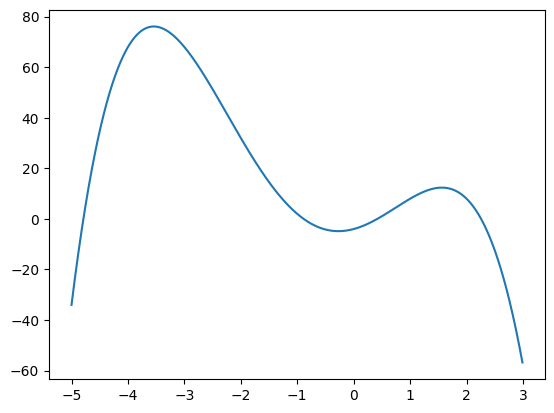

In [3]:
def plot_f(show=True, f_min=f_min, f_max=f_max, ratio=100):
    ratio = int(ratio)
    x = [x/ratio for x in range(int(f_min*ratio), int(f_max*ratio))]
    y = [f(x) for x in x]
    plt.plot(x, y, "-")
    if show:
        plt.show()
plot_f()

The **objective function** of a GA problems is the function we try to optimize (i.e. to find the minimum or the maximum). Here, the objective function is $f$.

## Score

The **score** of a solution $x\in \mathcal{C}$ is the value $f(x)$ of the objective function at this point. If you want to find the minimum of $f$, simply find the maximum of $-f$.

We says that a solution $x$ is **better** than a solution $y$ (denoted as $x \preceq y$) if and only if $f(x) \geq f(y)$. A solution $x$ is **strickly better** than a solution $y$ (denoted as $x \prec y$) if and only if $f(x) > f(y)$.

The **best solution** is $\underset{x\in\mathcal{C}}{argmax} \{f(x)\}$.

In [4]:
def S(x):
    return f(x)  # to find the maximum of f
    # return -f(x) # to find the minimum of f

## Generation

### Population

A **population** $P$ is a set of feasible solutions. $\forall k \leq  |P|$, we denote by $P[k]$ the $k$-th better solution of $P$. Then, $\forall i,j$, if $i\leq j$ then $P[i] \preceq P[j]$.

It is equivalent to said that $P$ is a vector sorted with the function $x \mapsto -\mathcal{S}(x)$.

Genetic algorithms follow the natural selection process. Then it takes a population $P_n$ and try to construct an other population $P_{n+1}$ based on the best solutions of $P_n$. We will contructed the population $P_{n+1}$ by keeping a proportion $\varepsilon_0$ of the best solutions of $P_n$, adding $\varepsilon_1$ cross-over, $\varepsilon_2$ mutations and $\varepsilon_3$ random new solutions. With $\varepsilon_0,\varepsilon_1,\varepsilon_2,\varepsilon_3$ some constant $\in [0,1]$. Going from $P_n$ to $P_{n+1}$ is called a generation. We will repeat this a fixed `NB_GEN` $\in \mathbb{N}$ number of time.

A genetic algorithm is the following:
 - Construct a first random population $P_0$
 - for i=1 to M:
    - construct $P_{i}$ from $P_{i+1}$
 - return $P_M$

For the programation part, we want all the population to have a fixed size `LEN_POP` $\in \mathbb{N}$. Otherwise, population might overgrow and these leed to exponential times of computation. Then $\varepsilon_0 + \varepsilon_1 + \varepsilon_2 + \varepsilon_3 =$ `LEN_POP`.

In [5]:
LEN_POP = 100
NB_GEN = 15

### Cenerate solution

As said previously, we want to be able to generate random solution and random population for our problem. Nevertheless, the score function can take a long time to be compute, therefore, we want to calculate the score of a solution only once. Thus we will create a python class caleed `Solution` to store the solution and its score.

In [6]:
class Solution():
    def __init__(self, sol, score):
        self.sol = sol
        self.score = score

In [7]:
def gen_sol():
    x = rd.uniform(f_min, f_max) # Generate random real number between f_min and f_max
    return Solution(x, S(x))

def gen_pop():
    return [gen_sol() for _ in range(LEN_POP)]

Notice that the function `gen_pop()` stays the same no matter the problem.

Let's visualise a random population.

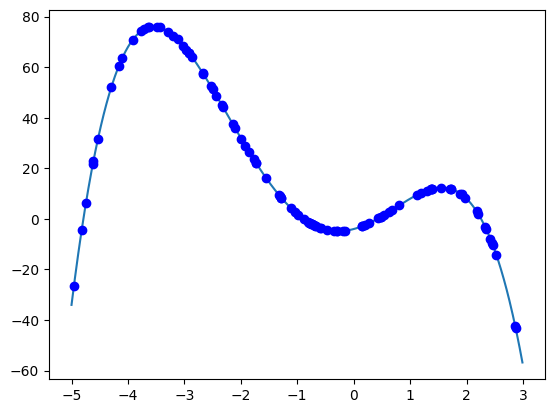

In [8]:
plot_f(show=False)
pop = gen_pop()

def plot_pop(pop, color, legend=""):
    solutions = [sol.sol for sol in pop]
    solutions_score = [S(sol) for sol in solutions]
    plt.plot(solutions, solutions_score, 'o', color=color, label=legend)

plot_pop(pop, "blue")
plt.show()

### Cross-over

Genetic algorithms are based on two main heuristic: cross-over and mutation.

A **cross-over** of two solutions $x$ and $y$ is an other solution $\phi(x,y)$ such that $\phi(x,y)$ try to fit as best as possible the similarities of $x$ and $y$. A cross-over is the equivalent of natural reproduction. The cross-over of $x$ and $y$ is often called the **child** of $x$ and $y$.

For example:
 - if $\mathcal{C} = \mathbb{R}$, a good cross-over is $\phi : (x,y) \mapsto \frac{x+y}{2}$
 - if $\mathcal{C} = \mathbb{R}^n$, a good cross-over is $\phi : ((x_i)_{1\leq i\leq n},(y_i)_{1\leq i\leq n}) \mapsto (\frac{x_i+y_i}{2})_{1\leq i\leq n}$

You will see other example where the solution are some list, graphs or new class in tutorials.

In [9]:
def cross_over(x:Solution, y:Solution):
    z = (x.sol + y.sol)/2
    return Solution(z, S(z))

Let's visualize what some cross_over.

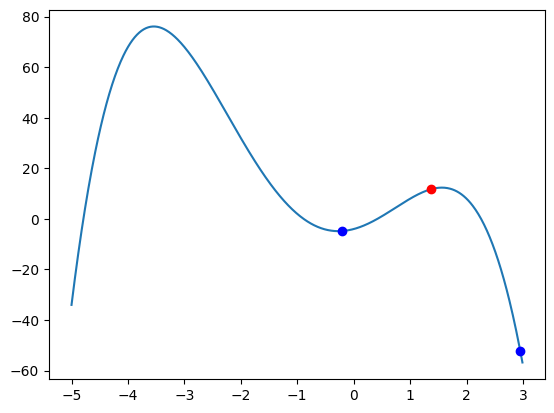

In [10]:
x = gen_sol()
y = gen_sol()
z = cross_over(x, y)

plot_f(show=False)
plt.plot(x.sol, x.score, "o", color="blue")
plt.plot(y.sol, y.score, "o", color="blue")
plt.plot(z.sol, z.score, "o", color="red")
plt.show()

### Mutations

As you may know, in genetics, some mutation randomly appear and create new solution that can be better or worst.

The **mutation** of a solution $x$ is a slight modification $\psi(x)$ of $x$.

For example:
 - if $\mathcal{C} = \mathbb{R}$, a good cross-over is $\psi : x \mapsto x + \delta$, for some small $\delta \in \mathbb{R}$.
 - if $\mathcal{C} = \mathbb{R}^n$, a good cross-over is $\phi : (x_i)_{1\leq i\leq n} \mapsto (x_i+p\delta)_{1\leq i\leq n}$, for some small $\delta \in \mathbb{R}$ and $p = 1$ with some fix probability and $0$ otherwise.

You will see other example where the solution are some list, graphs or new class in tutorials.

In [11]:
def mutate(x: Solution):
    delta = rd.random()/2
    y = x.sol + delta * (-1) ** rd.randint(0,1)
    return Solution(y, S(y))

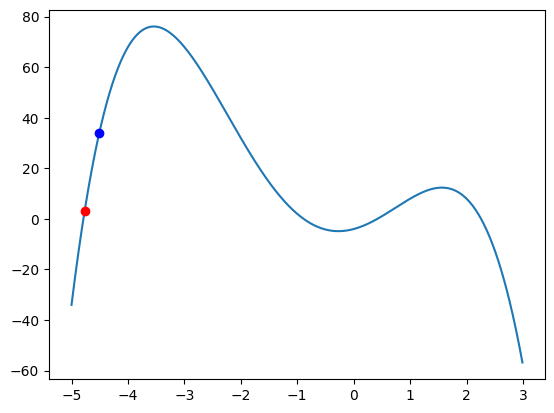

In [12]:
x = gen_sol()
y = mutate(x)

plot_f(show=False)
plt.plot(x.sol, x.score, "o", color="blue")
plt.plot(y.sol, y.score, "o", color="red")
plt.show()

## Creating $P_{n+1}$

### Sorting population

As said previously, we want that $\forall i,j$ such that $i\leq j$ we have $S(pop[i]) \geq S(pop[j])$. Then we want to sort the population `pop`.

In [13]:
def sort_pop(pop):
    pop.sort(key=lambda x:-x.score)

sort_pop(pop)

### Constants

First we define all the constant $\varepsilon_0, \varepsilon_1, \varepsilon_2$ called hyperparameter with good value for this problem. If you do some reinforcment learning project, you will have to play with hyper parameter to find best solution in as less time as possible. Then $\varepsilon_3 = 1-\varepsilon_0 - \varepsilon_1 -  \varepsilon_2$.

Depending of the problem, you will want to add more mutations or cross_over.

In [14]:
epsilon_0 = 0.3
epsilon_1 = 0.3
epsilon_2 = 0.2
epsilon_3 = 1 - epsilon_0 - epsilon_1 - epsilon_2

print(epsilon_0, epsilon_1, epsilon_2, epsilon_3)

0.3 0.3 0.2 0.19999999999999996


### Kept solutions

First, we will keep the $\varepsilon_0$ best solution of the population `pop`.

In [15]:
def np_keep(pop):
    new_pop = []
    for i in range(int(epsilon_0 * LEN_POP)):
        new_pop.append(pop[i])
    return new_pop

[]

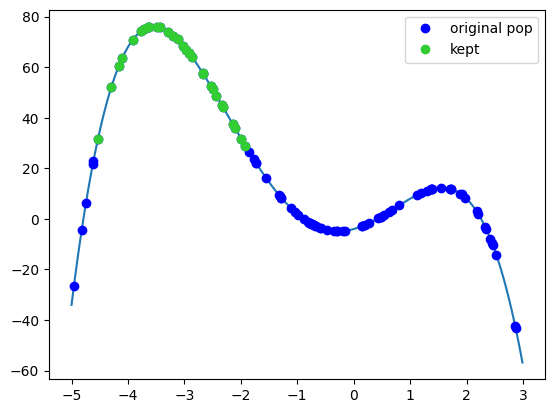

In [16]:
kept = np_keep(pop)
plot_f(False)
plot_pop(pop, "blue", "original pop")
plot_pop(kept, "limegreen", "kept")
plt.legend(loc="upper right")
plt.plot()

### Cross-Over

Note that its seems better to make child of two good solutions of $P_n$ than with two random solution of $P_n$.

Then we want a $K\in \mathbb{N}$ such that
$$|\{\phi(P_n[i], P_n[j]),\; i\in\{1,...,K\}, j \in \{i+1,...,K\}\}| = K$$

Therefore,
$$K = \lfloor \frac{1 + \sqrt{1+8\varepsilon_1}}{2} \rfloor$$

In [17]:
def np_cross_over(pop):
    new_pop = []
    K = int( (1 + math.sqrt(1 + 8*epsilon_1*LEN_POP)) / 2 )
    for i in range(K):
        for j in range(i+1, K):
            new_pop.append(cross_over(pop[i], pop[j]))
    return new_pop

[]

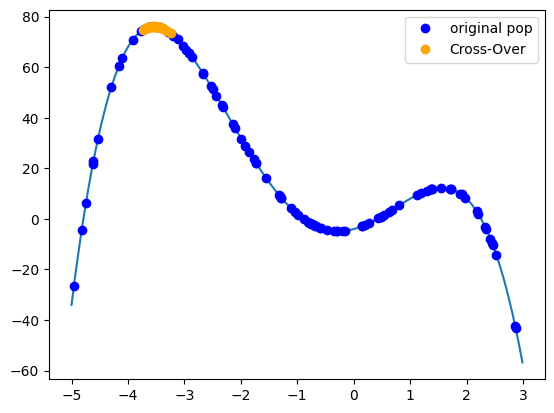

In [18]:
cross_overs = np_cross_over(pop)
plot_f(False)
plot_pop(pop, "blue", "original pop")
plot_pop(cross_overs, "orange", "Cross-Over")
plt.legend(loc="upper right")
plt.plot()

### Mutations

Similarily, its seems better to make mutations from the best solutions.

Then we want to add :
$$\{\psi(P_n[i]),\; i\in\{1,...,\lfloor \varepsilon_2 . LEN\_ POP\rfloor\}\}$$

In [19]:
def np_mutation(pop):
    new_pop = []
    for i in range(int(LEN_POP*epsilon_2)):
        new_pop.append(mutate(pop[i]))
    return new_pop

[]

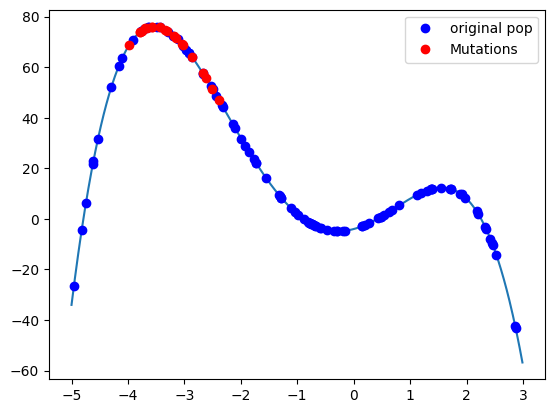

In [20]:
mutations = np_mutation(pop)
plot_f(False)
plot_pop(pop, "blue", "original pop")
plot_pop(mutations, "red", "Mutations")
plt.legend(loc="upper right")
plt.plot()

### New solutions

Then, we add the $\varepsilon_3$ new random solutions.

In [21]:
def np_new_solutions(pop):
    new_pop = []
    for _ in range(int(epsilon_3 * LEN_POP)):
        new_pop.append(gen_sol())
    return new_pop

[]

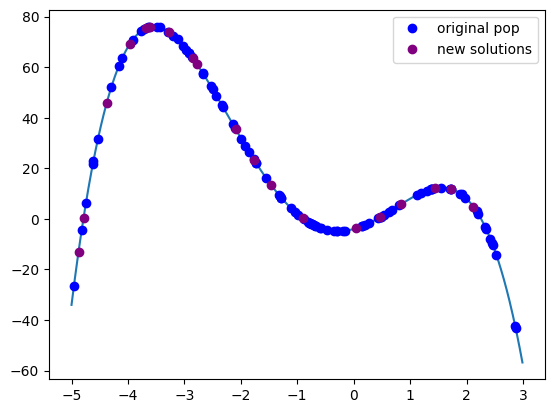

In [22]:
news = np_new_solutions(pop)
plot_f(False)
plot_pop(pop, "blue", "original pop")
plot_pop(news, "purple", "new solutions")
plt.legend(loc="upper right")
plt.plot()

### Complete function

In [23]:
def create_next_pop(pop, show=False):
    # pop is supposed to be sorted
    kept = np_keep(pop)
    cross_overs = np_cross_over(pop)
    mutations = np_mutation(pop)
    news = np_new_solutions(pop)
    
    if show: 
        plot_f(False)
        plot_pop(pop, "blue", "original pop")
        plot_pop(kept, "limegreen", "kept")
        plot_pop(cross_overs, "orange", "cross-over")
        plot_pop(mutations, "red", "mutation")
        plot_pop(news, "purple", "new solutions")
        plt.legend(loc="upper right")
        plt.plot()
    new_pop = kept + cross_overs + mutations + news
    return new_pop

97


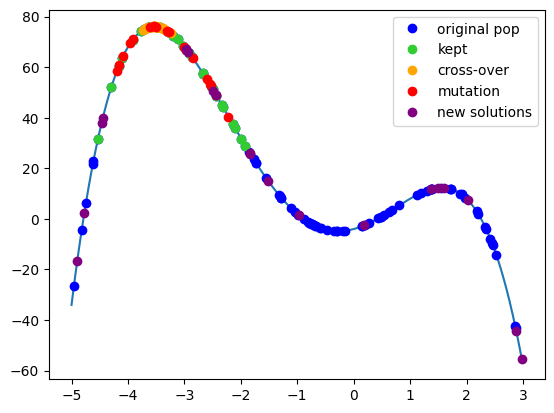

In [24]:
next_pop = create_next_pop(pop, True)
print(len(next_pop))

## Algorithm

Finally, we just have to compute the next generation `NB_GEN` time.

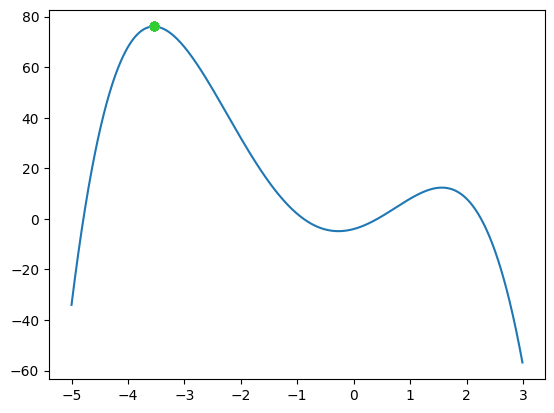

14 

In [25]:
def aglo_gen(show=False):
    pop = gen_pop()
    for gen in range(NB_GEN):
        sort_pop(pop)
        pop = create_next_pop(pop)

        if show:
            new_f_max = pop[0].score
            new_f_min = pop[0].score

            for i in range(1,10):
                if pop[i].score > new_f_max:
                    new_f_max = pop[i].score
                if pop[i].score < new_f_min:
                    new_f_min = pop[i].score

            plot_f(show=False)
            pop_to_print = pop[:10]
            plot_pop(pop_to_print, "limegreen")
            display.clear_output(wait=True)
            plt.show()
            time.sleep(0.1)
            print(gen, end=" ")
    return pop[0] #The best solution the algo found

best = aglo_gen(show=True)

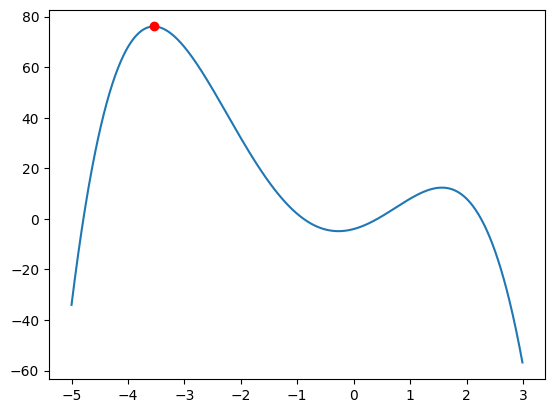

In [26]:
plot_f(False)
plt.plot(best.sol, best.score, "o", color="red")

# Genetic Algorithm class

## Explanation

We provide you a class named `GeneticAlgo` and `Solution` for coding genetic algorithm.

In [27]:
from GeneticAlgo import Solution, GeneticAlgo

## Exercice 1

Use the provided class to find the maximum of previous function and plot it.

### Solution

In [28]:
class MyAlgo(GeneticAlgo):
    def __init__(self, nb_gen=15, len_pop=100):
        super().__init__(nb_gen, len_pop)

    def score(self, x):
        return f(x)
        
    def gen_sol(self):
        x = rd.uniform(f_min, f_max)
        return Solution(x, self.score(x))

    def cross_over(self, x, y):
        z = (x.sol+y.sol)/2
        return [Solution(z, self.score(z))]
    
    def mutate(self, x):
        z = x.sol + (-1)**rd.randint(0,1) * rd.random()/2
        return [Solution(z, self.score(z))]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
-3.542052408203017 76.1207340115657


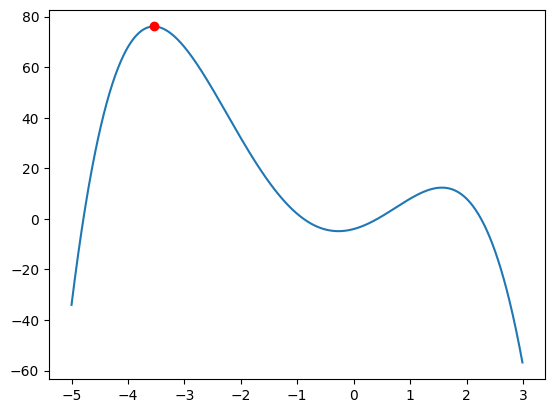

In [29]:
best_sol = MyAlgo().algo()[0]
print()
print(best_sol.sol, best_sol.score)

plot_f(False)
plt.plot(best_sol.sol, best_sol.score, "o", color="red")
plt.show()

## Exercice 2

TODO: use those to class to find the minimum of the following function.

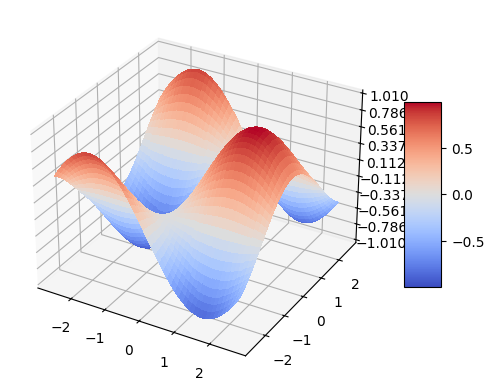

In [ ]:
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator


def f(x,y):
    return np.sin(x) * np.cos(y)

def plot_f():
    ratio = 100
    X = np.arange(-np.pi/1.2, np.pi/1.2, 1/ratio)
    Y = np.arange(-np.pi/1.2, np.pi/1.2, 1/ratio)
    X, Y = np.meshgrid(X, Y)
    Z = f(X,Y)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    # Customize the z axis.
    ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
plot_f()